In [1]:
import os
import json
from glob import glob
import random

import torch
import einops
import pandas as pd
import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

import shared.utils as su
from notebooks.eval_care_retrieval import load_data

In [264]:
models = [
    # '/work/piyush/pretrained_checkpoints/CaRe-7B/',
    '/work/piyush/experiments/CaRe/Tarsier-7b/final-10112025/nli_9000+ego_1000+subj_replaced-seed_42/merged_checkpoint',
]
datasets = [
    # 'ssv2',
    # 'epic',
    'charades',
]

K = 2

for model_id in models:
    for dataset in datasets:
        print("Model ID: ", model_id)
        print("Dataset: ", dataset)

        save_dir = f"{model_id}/metadata_results"
        os.makedirs(save_dir, exist_ok=True)
        save_path = f"{save_dir}/{dataset}_examples.pt"
        data = torch.load(save_path)

        df = data['dataframe']
        video_embeddings = data['video_embeddings']
        text_embeddings = data['text_embeddings']

        texts = [t for t in text_embeddings]
        zt = torch.stack([text_embeddings[t] for t in text_embeddings])
        video_ids = [t for t in video_embeddings]
        zv = torch.stack([video_embeddings[t] for t in video_embeddings])

        # For each text, retrieve the topK videos
        sim = zt @ zv.T
        # topk_indices = sim.topk(dim=-1)
        # print(zv.shape, zt.shape, topk_indices.shape)
    

Model ID:  /work/piyush/experiments/CaRe/Tarsier-7b/final-10112025/nli_9000+ego_1000+subj_replaced-seed_42/merged_checkpoint
Dataset:  charades


In [265]:
topk_indices = sim.topk(k=K, dim=-1).indices
topk_indices.shape

torch.Size([56, 2])

In [266]:
video_id_to_path = dict(df[['id', 'video_path']].values)
len(video_id_to_path)

112

In [267]:
video_id_to_text = dict(df[['id', 'template']].values)
len(video_id_to_text)

112

In [268]:
df

,id_base,subject,scene,quality,relevance,verified,length,cls_id,template,start_time,...,object_id,noun,verb_id,verb,label,id,chiral_label,chiral_triplet_id,text_id,video_path
2200,J0AMJ,ZDKC,Bedroom,4.0,7.0,Yes,30.67,c077,putting a pillow somewhere,15.1,...,o027,na,v016,put,putting a pillow somewhere,J0AMJ_15.1_30.7,0.0,a9be73ec,a9be73ec_0.0,/scratch/shared/beegfs/piyush/datasets/Charade...
4139,BM9NZ,P2J3,Bedroom,5.0,7.0,Yes,33.67,c077,putting a pillow somewhere,11.6,...,o027,na,v016,put,putting a pillow somewhere,BM9NZ_11.6_16.4,0.0,a9be73ec,a9be73ec_0.0,/scratch/shared/beegfs/piyush/datasets/Charade...
3511,1KC11,M7K8,Recreation room / Man cave,6.0,5.0,Yes,36.04,c154,someone is standing up from somewhere,27.6,...,o000,na,v022,stand,someone is standing up from somewhere,1KC11_27.6_32.1,1.0,e3c2c932,e3c2c932_1.0,/scratch/shared/beegfs/piyush/datasets/Charade...
881,S7OTQ,GFWE,Kitchen,6.0,7.0,Yes,30.83,c154,someone is standing up from somewhere,13.7,...,o000,na,v022,stand,someone is standing up from somewhere,S7OTQ_13.7_20.4,1.0,e3c2c932,e3c2c932_1.0,/scratch/shared/beegfs/piyush/datasets/Charade...
663,TBRZ5,BONA,Basement (A room below the ground floor),5.0,5.0,Yes,31.54,c151,someone is going from standing to sitting,0.0,...,o000,na,v018,sit,someone is going from standing to sitting,TBRZ5_0.0_17.0,0.0,e3c2c932,e3c2c932_0.0,/scratch/shared/beegfs/piyush/datasets/Charade...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4490,3C1ZN,JTAS,Living room,4.0,4.0,Yes,30.75,c079,taking a pillow from somewhere,23.3,...,o027,na,v023,take,taking a pillow from somewhere,3C1ZN_23.3_27.5,1.0,a9be73ec,a9be73ec_1.0,/scratch/shared/beegfs/piyush/datasets/Charade...
1516,I87SH,B6UG,Home Office / Study (A room in a house used fo...,5.0,7.0,Yes,31.04,c090,opening a window,18.8,...,o037,na,v012,open,opening a window,I87SH_18.8_31.0,1.0,aba2fe34,aba2fe34_1.0,/scratch/shared/beegfs/piyush/datasets/Charade...
1699,X11CU,AT5D,Dining room,6.0,6.0,Yes,31.50,c090,opening a window,3.2,...,o037,na,v012,open,opening a window,X11CU_3.2_13.2,1.0,aba2fe34,aba2fe34_1.0,/scratch/shared/beegfs/piyush/datasets/Charade...
1996,J59UP,BPXZ,Living room,6.0,6.0,Yes,30.83,c060,standing on a chair,0.0,...,o007,na,v022,stand,standing on a chair,J59UP_0.0_5.9,1.0,53775bec,53775bec_1.0,/scratch/shared/beegfs/piyush/datasets/Charade...


In [269]:
text_id_to_target = dict(df[['text_id', 'template']].values)
len(text_id_to_target)

56

In [270]:
def show_retrieval_samples(video_paths: list, query: str, retrieved: list, nframes=2):
    frames = [
        su.visualize.concat_images_with_border(su.video.load_frames_linspace(f, n=nframes, width=256, height=224)) \
        for f in video_paths
    ]
    colors = [
        'limegreen' if query == retrieved[i] else 'red' for i in range(len(retrieved))
    ]
    frames = [su.visualize.add_frame_around_image(f, c, thickness=7) for f, c in zip(frames, colors)]
    # canvas = su.visualize.concat_images_vertically_with_border(frames)
    image = su.visualize.show_grid_of_images(
        images=frames,
        n_cols=1,
        subtitles=retrieved,
        return_as_pil=True,
        show=False,
        # figsize=(4, 6),
        figsize=(4, 4),
        subtitlesize=11,
    )
    return image

In [271]:
images = []
queries = []
for i in su.log.tqdm_iterator(range(len(topk_indices))):
    pred_video_ids = [video_ids[j] for j in topk_indices[i]]
    pred_video_paths = [video_id_to_path[x] for x in pred_video_ids]
    
    # Check correctness
    pred_texts = [video_id_to_text[x] for x in pred_video_ids]
    gt_text = text_id_to_target[texts[i]]
    corrects = [gt_text == x for x in pred_texts]

    # print(gt_text, pred_texts)
    image = show_retrieval_samples(pred_video_paths, gt_text, pred_texts)
    images.append(image)
    queries.append(gt_text)
    
# pred_video_paths, corrects

  0%|          | 0/56 [00:00<?, ?it/s]

23
closing a laptop


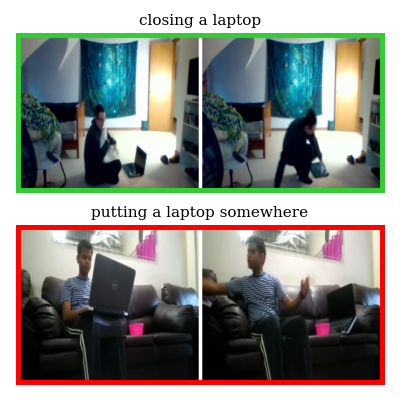

In [272]:
# i = 0 # SSv2
# i = 7 # SSv2

# i = 96
# i = 123
# i = 89
# i = 98

# i = 8
# i = 24
# i = 16
# i = 48
i = 23 
# i = np.random.randint(len(images))
print(i)

image = images[i]
query = queries[i]
print(query)
image

In [273]:
image.save('image.png')

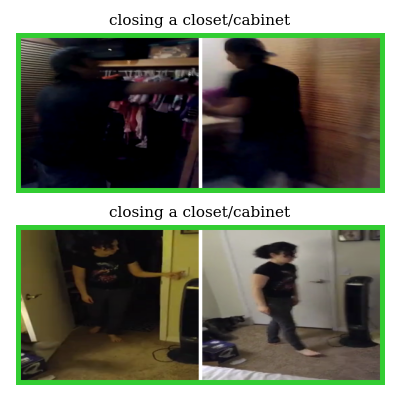

In [242]:
pred_video_ids = [video_ids[j] for j in topk_indices[i]]
pred_video_paths = [video_id_to_path[x] for x in pred_video_ids]

# Check correctness
pred_texts = [video_id_to_text[x] for x in pred_video_ids]
gt_text = text_id_to_target[texts[i]]
corrects = [1, 1]
image = show_retrieval_samples(pred_video_paths, pred_texts[0], pred_texts)
image

In [243]:
image.save('image.png')